<a href="https://colab.research.google.com/github/starirene9/DeepLearningAssignment/blob/main/Dropout%26L2%26BatchNorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision.transforms as T
from torchvision.datasets import MNIST

실행에서 randomness 제어

In [2]:
random.seed(5106)
np.random.seed(5106)
torch.manual_seed(5106)
torch.cuda.manual_seed(5106)
torch.cuda.manual_seed_all(5106)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
def get_acc_loss(model, loader, loss_fn=None):
    model.eval() # 	모델을 평가 모드로 전환
    with torch.no_grad():
        loss = []
        total, correct = 0, 0 # 전체 샘플 수(total)와 맞힌 개수(correct)를 0으로 초기화
        for imgs, targets in loader:
            imgs = imgs.flatten(1).cuda()
            targets = targets.cuda()

            logits = model(imgs) # 이미지를 모델에 넣어서 예측 결과(logits)를 받아요

            if loss_fn:
                loss.append(float(loss_function(logits, targets).cpu()))

            _, preds = torch.max(logits.data, 1) # 각 샘플에서 가장 높은 점수를 가진 클래스 인덱스를 preds로 저장
            #  값은 무시하고 인덱스만 가져오겠다
            total += targets.size(0)
            correct += (preds == targets).sum().item() #예측한 값과 정답이 같은 경우의 수를 세서 correct에 더해요.
            # item은 	tensor(3)을 숫자 3으로 바꿔줘요
        return 100 * correct / total, sum(loss) / max(len(loss), 1)

        """
        # 모델의 출력 (logits) - 5개 샘플, 3개의 클래스 점수라고 가정
        logits = torch.tensor([
            [2.0, 0.5, 1.0],   # 샘플 1 → 클래스 0이 제일 큼
            [0.1, 3.2, 0.5],   # 샘플 2 → 클래스 1이 제일 큼
            [1.5, 0.2, 2.2],   # 샘플 3 → 클래스 2가 제일 큼
            [0.3, 0.8, 0.5],   # 샘플 4 → 클래스 1이 제일 큼
            [4.0, 2.0, 3.5],   # 샘플 5 → 클래스 0이 제일 큼
        ])

        # 가장 높은 값의 인덱스를 찾기 (dim=1: 각 행마다)
        _, preds = torch.max(logits, 1)

        print("예측 클래스:", preds)  # tensor([0, 1, 2, 1, 0])
        """

In [4]:
EPOCH = 200
BATCH_SIZE = 10

In [5]:
# 6만개 학습 데이터 중 일부만 사용 (80개)
data_set = [i for i in range(60000)]
random.shuffle(data_set)
data_set = data_set[:80]

train = MNIST('./', train=True, download=True, transform=T.ToTensor())
test = MNIST('./', train=False, download=False, transform=T.ToTensor())

train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(data_set))
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, num_workers=3)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.10MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.76MB/s]


In [6]:
model = torch.nn.Sequential(torch.nn.Linear(28*28, 512),
                            torch.nn.ReLU(),
                            torch.nn.Linear(512, 256),
                            torch.nn.ReLU(),
                            torch.nn.Linear(256, 128),
                            torch.nn.ReLU(),
                            torch.nn.Linear(128, 64),
                            torch.nn.ReLU(),
                            torch.nn.Linear(64, 32),
                            torch.nn.ReLU(),
                            torch.nn.Linear(32, 10)).cuda()
state = {
    'model': model.state_dict(),
}
torch.save(state, 'model.pth')

In [7]:
model.load_state_dict(torch.load('model.pth')['model'])
loss_function = torch.nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

acc_lst, loss_lst = [[], []], [[], []]
for epoch in range(EPOCH):
    model.train()
    for img, target in train_loader:
        img = img.flatten(1).cuda()
        target = target.cuda()
        logit = model(img)

        optimizer.zero_grad()

        loss = loss_function(logit, target)

        loss.backward()
        optimizer.step()


    if not epoch % 4:
        train_acc, train_loss = get_acc_loss(model, train_loader, loss_function)
        test_acc, test_loss = get_acc_loss(model, test_loader, loss_function)
        acc_lst[0].append(train_acc)
        acc_lst[1].append(test_acc)
        loss_lst[0].append(train_loss)
        loss_lst[1].append(test_loss)
        if not epoch % 40:
            print(f'{epoch + 1} epoch - accuracy: {train_acc} / {test_acc} - loss: {train_loss} / {test_loss}')

1 epoch - accuracy: 16.25 / 14.16 - loss: 2.298960328102112 / 2.3024166145324707
41 epoch - accuracy: 100.0 / 59.75 - loss: 0.008362484746612608 / 2.231439121514559
81 epoch - accuracy: 100.0 / 60.4 - loss: 0.0011449359226389788 / 2.633355213898234
121 epoch - accuracy: 100.0 / 60.47 - loss: 0.0004434364254848333 / 2.8312184690926223
161 epoch - accuracy: 100.0 / 60.61 - loss: 0.0002314959820068907 / 2.9733189257038757


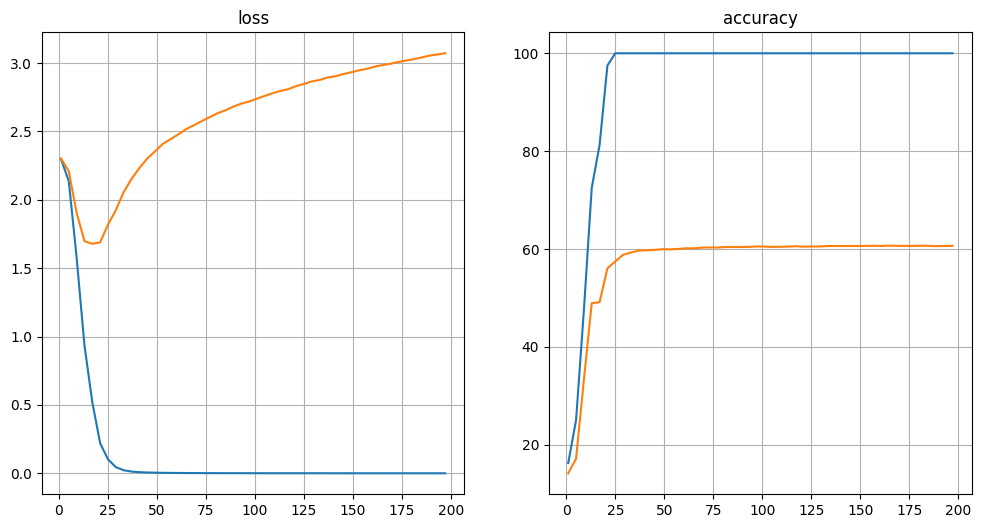

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title('loss')
axes[0].grid()
axes[0].plot([i for i in range(1, 200, 4)], loss_lst[0])
axes[0].plot([i for i in range(1, 200, 4)], loss_lst[1])

axes[1].set_title('accuracy')
axes[1].grid()
axes[1].plot([i for i in range(1, 200, 4)], acc_lst[0])
axes[1].plot([i for i in range(1, 200, 4)], acc_lst[1]) # -> overfitting 발생 확인

weight_decay : 규제 적용
규제가 너무 강하면 언더 피팅이 됨

In [9]:
model.load_state_dict(torch.load('model.pth')['model'])

loss_function = torch.nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-3)

acc_lst, loss_lst = [[], []], [[], []]
for epoch in range(EPOCH):
    model.train()
    for img, target in train_loader:
        img = img.flatten(1).cuda()
        target = target.cuda()
        logit = model(img)

        optimizer.zero_grad()

        loss = loss_function(logit, target)

        loss.backward()
        optimizer.step()


    if not epoch % 4:
        train_acc, train_loss = get_acc_loss(model, train_loader, loss_function)
        test_acc, test_loss = get_acc_loss(model, test_loader, loss_function)
        acc_lst[0].append(train_acc)
        acc_lst[1].append(test_acc)
        loss_lst[0].append(train_loss)
        loss_lst[1].append(test_loss)
        if not epoch % 40:
            print(f'{epoch + 1} epoch - accuracy: {train_acc} / {test_acc} - loss: {train_loss} / {test_loss}')

1 epoch - accuracy: 12.5 / 10.37 - loss: 2.299846351146698 / 2.3030028932094573
41 epoch - accuracy: 100.0 / 59.57 - loss: 0.015336897457018495 / 2.391534011086449
81 epoch - accuracy: 100.0 / 59.93 - loss: 0.0045132876839488745 / 2.5220943591408433
121 epoch - accuracy: 100.0 / 59.95 - loss: 0.0029401214560493827 / 2.4460255234325303
161 epoch - accuracy: 100.0 / 59.87 - loss: 0.0023914354387670755 / 2.357003444782458


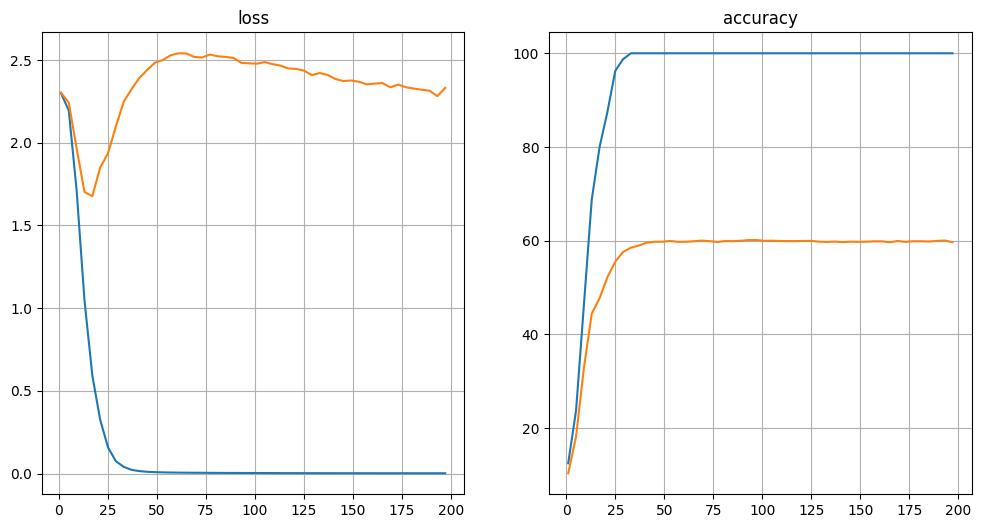

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title('loss')
axes[0].grid()
axes[0].plot([i for i in range(1, 200, 4)], loss_lst[0])
axes[0].plot([i for i in range(1, 200, 4)], loss_lst[1])

axes[1].set_title('accuracy')
axes[1].grid()
axes[1].plot([i for i in range(1, 200, 4)], acc_lst[0])
axes[1].plot([i for i in range(1, 200, 4)], acc_lst[1]) # -> overfitting 발생 확인

Batch normalization 활성화함수 적용 전에 적용

In [11]:
model = torch.nn.Sequential(torch.nn.Linear(28*28, 512),
                            torch.nn.BatchNorm1d(512),
                            torch.nn.ReLU(),
                            torch.nn.Linear(512, 256),
                            torch.nn.BatchNorm1d(256),
                            torch.nn.ReLU(),
                            torch.nn.Linear(256, 128),
                            torch.nn.BatchNorm1d(128),
                            torch.nn.ReLU(),
                            torch.nn.Linear(128, 64),
                            torch.nn.BatchNorm1d(64),
                            torch.nn.ReLU(),
                            torch.nn.Linear(64, 32),
                            torch.nn.BatchNorm1d(32),
                            torch.nn.ReLU(),
                            torch.nn.Linear(32, 10)).cuda()

In [12]:
loss_function = torch.nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

acc_lst, loss_lst = [[], []], [[], []]
for epoch in range(EPOCH):
    model.train()
    for img, target in train_loader:
        img = img.flatten(1).cuda()
        target = target.cuda()
        logit = model(img)

        optimizer.zero_grad()

        loss = loss_function(logit, target)

        loss.backward()
        optimizer.step()


    if not epoch % 4:
        train_acc, train_loss = get_acc_loss(model, train_loader, loss_function)
        test_acc, test_loss = get_acc_loss(model, test_loader, loss_function)
        acc_lst[0].append(train_acc)
        acc_lst[1].append(test_acc)
        loss_lst[0].append(train_loss)
        loss_lst[1].append(test_loss)
        if not epoch % 40:
            print(f'{epoch + 1} epoch - accuracy: {train_acc} / {test_acc} - loss: {train_loss} / {test_loss}')

1 epoch - accuracy: 8.75 / 9.82 - loss: 2.331541985273361 / 2.313060426712036
41 epoch - accuracy: 100.0 / 64.37 - loss: 0.4540480226278305 / 1.4799228583574295
81 epoch - accuracy: 100.0 / 66.55 - loss: 0.14976190216839314 / 1.2219308942258358
121 epoch - accuracy: 100.0 / 64.08 - loss: 0.06570070097222924 / 1.203976253271103
161 epoch - accuracy: 100.0 / 65.26 - loss: 0.0380090456455946 / 1.1656840194016695


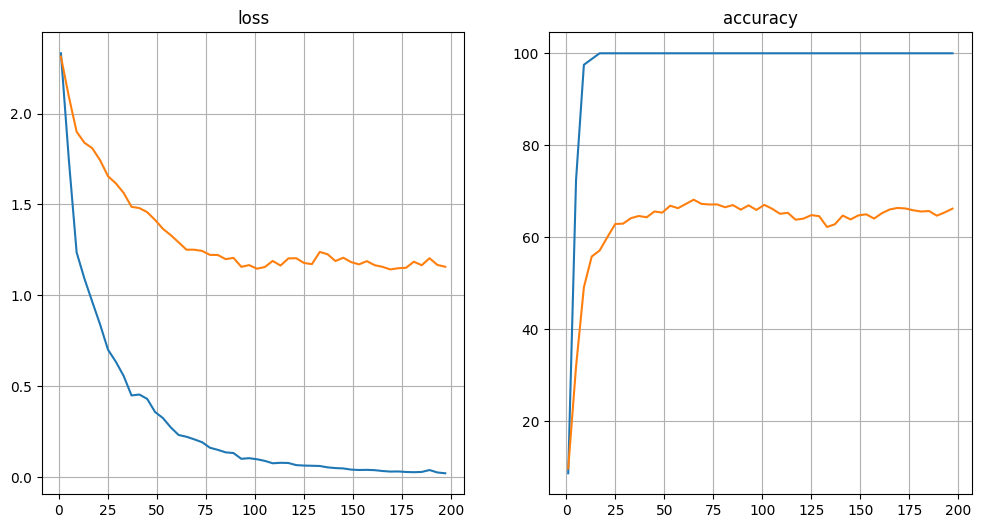

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title('loss')
axes[0].grid()
axes[0].plot([i for i in range(1, 200, 4)], loss_lst[0])
axes[0].plot([i for i in range(1, 200, 4)], loss_lst[1])

axes[1].set_title('accuracy')
axes[1].grid()
axes[1].plot([i for i in range(1, 200, 4)], acc_lst[0])
axes[1].plot([i for i in range(1, 200, 4)], acc_lst[1]) # -> overfitting 발생 확인

Dropout 0.5 default 값으로 사용 많이 함

In [14]:
model = torch.nn.Sequential(torch.nn.Linear(28*28, 512),
                            torch.nn.Dropout(0.5),
                            torch.nn.ReLU(),
                            torch.nn.Linear(512, 256),
                            torch.nn.Dropout(0.5),
                            torch.nn.ReLU(),
                            torch.nn.Linear(256, 128),
                            torch.nn.Dropout(0.5),
                            torch.nn.ReLU(),
                            torch.nn.Linear(128, 64),
                            torch.nn.Dropout(0.5),
                            torch.nn.ReLU(),
                            torch.nn.Linear(64, 32),
                            torch.nn.Dropout(0.5),
                            torch.nn.ReLU(),
                            torch.nn.Linear(32, 10)).cuda()

In [15]:
loss_function = torch.nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

acc_lst, loss_lst = [[], []], [[], []]
for epoch in range(EPOCH*3):
    model.train()
    for img, target in train_loader:
        img = img.flatten(1).cuda()
        target = target.cuda()
        logit = model(img)

        optimizer.zero_grad()

        loss = loss_function(logit, target)

        loss.backward()
        optimizer.step()


    if not epoch % 4:
        train_acc, train_loss = get_acc_loss(model, train_loader, loss_function)
        test_acc, test_loss = get_acc_loss(model, test_loader, loss_function)
        acc_lst[0].append(train_acc)
        acc_lst[1].append(test_acc)
        loss_lst[0].append(train_loss)
        loss_lst[1].append(test_loss)
        if not epoch % 40:
            print(f'{epoch + 1} epoch - accuracy: {train_acc} / {test_acc} - loss: {train_loss} / {test_loss}')

1 epoch - accuracy: 5.0 / 8.92 - loss: 2.3105589747428894 / 2.3092833411693574
41 epoch - accuracy: 50.0 / 35.7 - loss: 1.6741956323385239 / 2.0247780824899673
81 epoch - accuracy: 65.0 / 42.79 - loss: 0.8817676529288292 / 1.7918463241159917
121 epoch - accuracy: 83.75 / 48.68 - loss: 0.5013612844049931 / 1.9079577279537916
161 epoch - accuracy: 90.0 / 55.36 - loss: 0.32795827370136976 / 2.1440954982824625
201 epoch - accuracy: 95.0 / 56.48 - loss: 0.22970080166123807 / 2.3477705124765635
241 epoch - accuracy: 95.0 / 59.33 - loss: 0.18322025437373668 / 2.23000258660689
281 epoch - accuracy: 95.0 / 58.53 - loss: 0.1615270383135794 / 2.5330452463058757
321 epoch - accuracy: 95.0 / 57.39 - loss: 0.1452063189326509 / 2.750563470359193
361 epoch - accuracy: 95.0 / 58.57 - loss: 0.12988461297936738 / 2.982859625795274
401 epoch - accuracy: 97.5 / 60.06 - loss: 0.11515212336598779 / 3.1245323931578315
441 epoch - accuracy: 95.0 / 60.55 - loss: 0.09466841211542487 / 3.1152525734676746
481 epoc

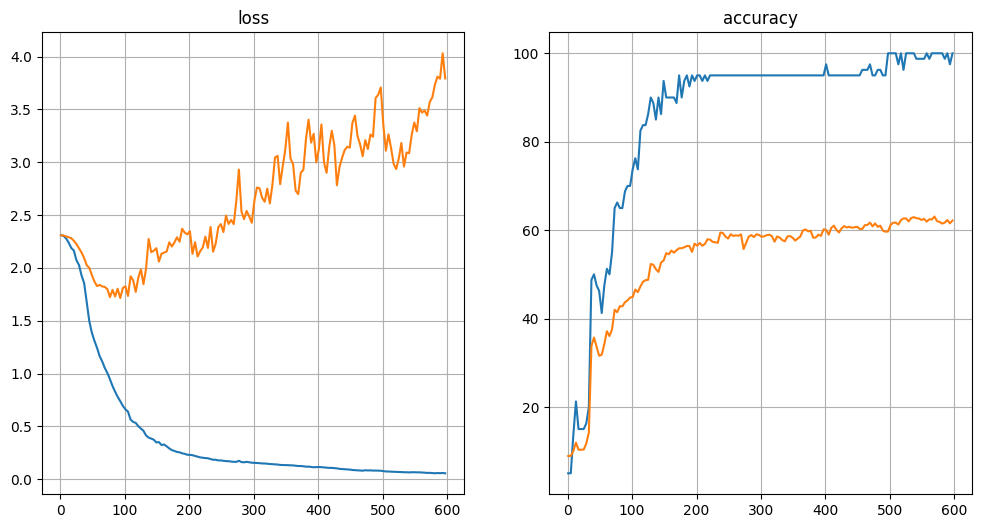

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title('loss')
axes[0].grid()
axes[0].plot([i for i in range(1, 600, 4)], loss_lst[0])
axes[0].plot([i for i in range(1, 600, 4)], loss_lst[1])

axes[1].set_title('accuracy')
axes[1].grid()
axes[1].plot([i for i in range(1, 600, 4)], acc_lst[0])
axes[1].plot([i for i in range(1, 600, 4)], acc_lst[1]) # -> overfitting 발생 확인

Dropout, 모델 사이즈 줄임, Batchnorm 넣음, Data Augumentation

In [17]:
# 6만개 학습 데이터 중 일부만 사용 (80개)
data_set = [i for i in range(60000)]
random.shuffle(data_set)
data_set = data_set[:128]

train_transform = T.Compose([
    T.RandomCrop(size=28, padding=2),
    T.RandomRotation(degrees=(-10, 10)),  # 좀 더 크게 회전
    T.ColorJitter(brightness=0.2, contrast=0.2),  # 밝기/대비 변화
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 위치 변화
    T.ToTensor(),
])

train = MNIST('./', train=True, download=True, transform=train_transform)
#train = MNIST('./', train=True, download=True, transform=T.ToTensor())
test = MNIST('./', train=False, download=False, transform=T.ToTensor())

train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(data_set))
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, num_workers=3)

In [18]:
model = torch.nn.Sequential(torch.nn.Linear(28*28, 128),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(0.3),
                            torch.nn.Linear(128, 64),
                            torch.nn.ReLU(),
                            torch.nn.Linear(64, 10)).cuda()

In [19]:
loss_function = torch.nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

acc_lst, loss_lst = [[], []], [[], []]
for epoch in range(EPOCH):
    model.train()
    for img, target in train_loader:
        img = img.flatten(1).cuda()
        target = target.cuda()
        logit = model(img)

        optimizer.zero_grad()

        loss = loss_function(logit, target)

        loss.backward()
        optimizer.step()


    if not epoch % 4:
        train_acc, train_loss = get_acc_loss(model, train_loader, loss_function)
        test_acc, test_loss = get_acc_loss(model, test_loader, loss_function)
        acc_lst[0].append(train_acc)
        acc_lst[1].append(test_acc)
        loss_lst[0].append(train_loss)
        loss_lst[1].append(test_loss)
        if not epoch % 40:
            print(f'{epoch + 1} epoch - accuracy: {train_acc} / {test_acc} - loss: {train_loss} / {test_loss}')

1 epoch - accuracy: 7.03125 / 8.61 - loss: 2.301633064563458 / 2.297303319692612
41 epoch - accuracy: 58.59375 / 62.52 - loss: 1.4242609739303589 / 1.1876532484591007
81 epoch - accuracy: 59.375 / 74.73 - loss: 1.1935057364977324 / 0.8519997683316469
121 epoch - accuracy: 73.4375 / 78.13 - loss: 0.8606549570193658 / 0.721376580581069
161 epoch - accuracy: 75.78125 / 79.17 - loss: 0.8705909756513742 / 0.664610475949943


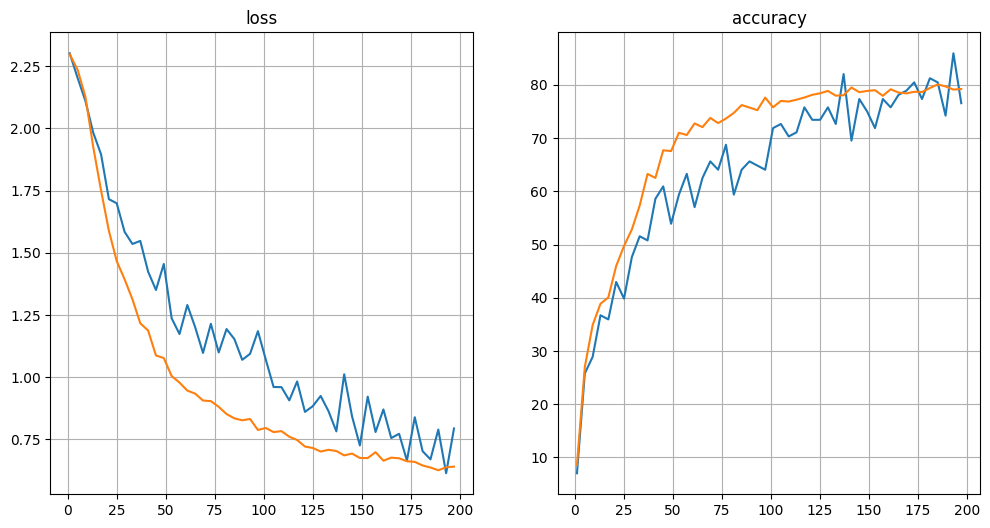

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title('loss')
axes[0].grid()
axes[0].plot([i for i in range(1, 200, 4)], loss_lst[0])
axes[0].plot([i for i in range(1, 200, 4)], loss_lst[1])

axes[1].set_title('accuracy')
axes[1].grid()
axes[1].plot([i for i in range(1, 200, 4)], acc_lst[0])
axes[1].plot([i for i in range(1, 200, 4)], acc_lst[1])